In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

# get data from my github
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv')   
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv')
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv')
print("Imports successful!")

Imports successful!


In [2]:
# combine last 3 years of contract data
df_combined = pd.concat([df_2020, df_2021, df_2022])

## EDA ##

In [3]:
df_combined.head()

,Unnamed: 0,Player,Years,Full_Salary,Avg_Salary,Pos,Age,Tm,G,GS,...,X,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP
0,1,Alec Burks,1,6000000.0,6000000.0,SF-SG,28,TOT,66,19,...,NaN,2.5,1.2,3.7,0.101,NaN,1.2,-0.7,0.5,1.1
1,2,Alex Len,1,2258000.0,2258000.0,C,26,TOT,55,12,...,NaN,1.5,1.0,2.5,0.122,NaN,-0.5,-0.3,-0.7,0.3
2,3,Anthony Davis,5,189903600.0,37980720.0,PF,26,LAL,62,62,...,NaN,6.7,4.4,11.1,0.250,NaN,5.4,2.6,8.0,5.4
3,4,Aron Baynes,2,14350000.0,7175000.0,C,33,PHO,42,28,...,NaN,1.3,0.8,2.1,0.107,NaN,-0.2,-0.8,-1.0,0.2
4,5,Austin Rivers,3,9975000.0,3325000.0,SG,27,HOU,68,4,...,NaN,1.2,1.2,2.4,0.072,NaN,-2.1,-0.4,-2.5,-0.2


In [4]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 77
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   313 non-null    int64  
 1   Player       313 non-null    object 
 2   Years        313 non-null    int64  
 3   Full_Salary  313 non-null    float64
 4   Avg_Salary   313 non-null    float64
 5   Pos          313 non-null    object 
 6   Age          313 non-null    int64  
 7   Tm           313 non-null    object 
 8   G            313 non-null    int64  
 9   GS           313 non-null    int64  
 10  MP           313 non-null    float64
 11  FG           313 non-null    float64
 12  FGA          313 non-null    float64
 13  FG.          313 non-null    float64
 14  X3P          313 non-null    float64
 15  X3PA         313 non-null    float64
 16  X3P.         304 non-null    float64
 17  X2P          313 non-null    float64
 18  X2PA         313 non-null    float64
 19  X2P.     

{'whiskers': [<matplotlib.lines.Line2D at 0x130ddfa78e0>,
 'caps': [<matplotlib.lines.Line2D at 0x130ddfa7fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x130ddfa7580>],
 'medians': [<matplotlib.lines.Line2D at 0x130ddfc06a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x130ddfc0a00>],
 'means': []}

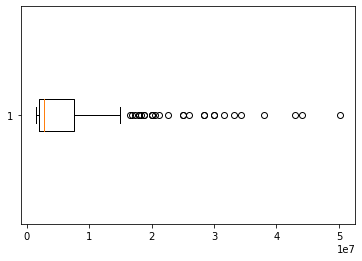

In [5]:
plt.boxplot(df_combined[['Avg_Salary']], notch=None, vert=False, patch_artist=None, widths=None)
# We see that salary is heavily skewed to the right

In [6]:
df_combined[['Avg_Salary']].skew()

Avg_Salary    2.808843
dtype: float64

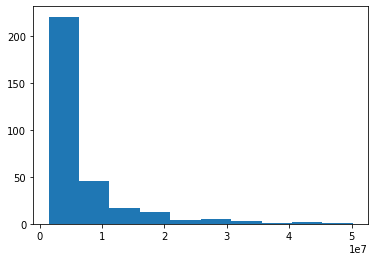

In [7]:
plt.hist(df_combined[['Avg_Salary']], bins=10)
plt.show()

In [8]:
log_df = np.log(df_combined[['Avg_Salary']])
log_df.skew()

Avg_Salary    0.905815
dtype: float64

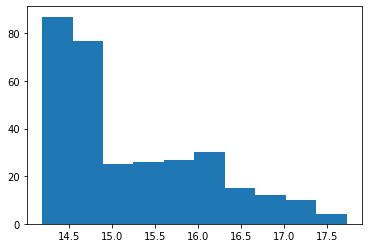

In [9]:
plt.hist(log_df, bins=10)
plt.show()
#Still right skewed but not as significantly

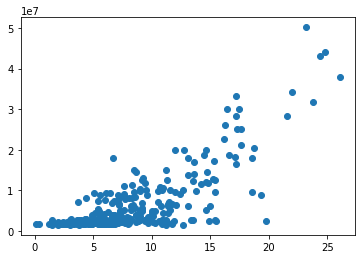

In [10]:
plt.plot(df_combined['PTS'],df_combined[['Avg_Salary']], 'o')
# PTS, an important indicator of contract value has more of an exponential then linear fit, so it is very possible a linear model would be incomplete

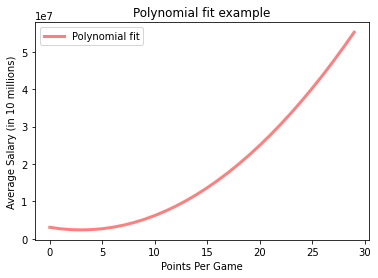

In [30]:
plt.plot(df_combined['PTS'],df_combined[['Avg_Salary']], 'o')
x = df_combined['PTS']
y = df_combined[['Avg_Salary']]
fit = np.polyfit(x, y, 2)
a = fit[0]
b = fit[1]
c = fit[2]
x1 = range(0,30,1)
fit_equation = a * np.square(x1) + b * x1 + c
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(x1, fit_equation,color = 'r',alpha = 0.5, linewidth = 3, label = 'Polynomial fit')

plt.xlabel("Points Per Game")
plt.ylabel("Average Salary (in 10 millions)")
ax1.set_title('Polynomial fit example')
ax1.legend()
plt.show()

Text(0.5, 1.0, 'VORP vs Average Salary')

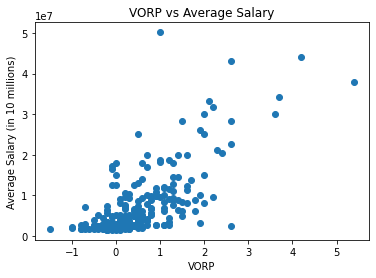

In [33]:
plt.plot(df_combined['VORP'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("VORP")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('VORP vs Average Salary')
# VORP has best correlation with salary among the advanced stats (PER, OBPM, DBPM)

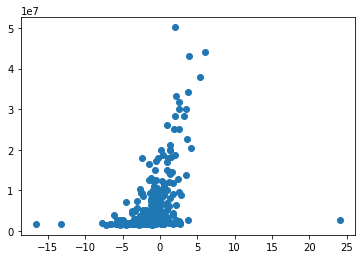

In [13]:
plt.plot(df_combined['OBPM'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("OBPM")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('OBPM vs Average Salary')

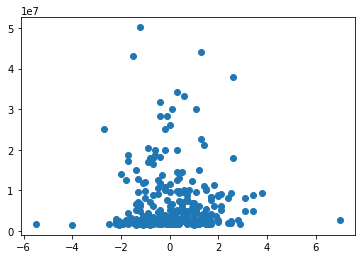

In [14]:
plt.plot(df_combined['DBPM'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("DBPM")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('DBPM vs Average Salary')

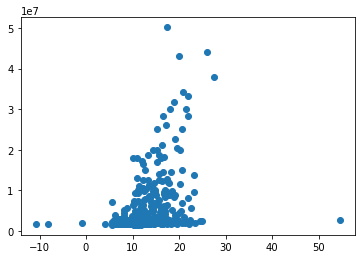

In [15]:
plt.plot(df_combined['PER'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("PER")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('PER vs Average Salary')

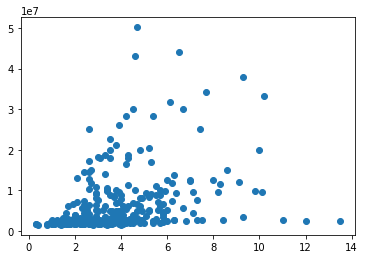

In [16]:
plt.plot(df_combined['TRB'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("Rebounds")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Total Rebounds vs Average Salary')
# A weak positive correlation for rebounding

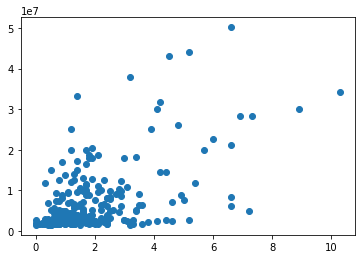

In [17]:
plt.plot(df_combined['AST'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("Assists")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Assists vs Average Salary')
# A mostly positive correlation for assists

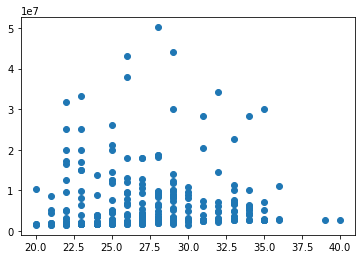

In [18]:
plt.plot(df_combined['Age'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("Age")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Age vs Average Salary')

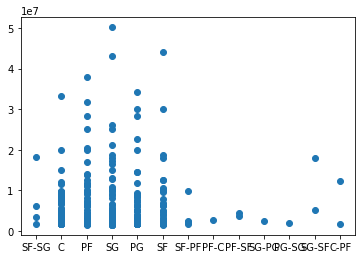

In [19]:
plt.plot(df_combined['Pos'],df_combined[['Avg_Salary']], 'o')
plt.xlabel("Position")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Average Salary by position')
# In recent years the highest paid players have been SGs and SFs, but overall no position is being paid significantly more

#### Since certain positions are generally paid to do specific things in basketball, I tried splitting the df into wings/guards and bigs

In [41]:
wings_df = df_combined[(df_combined.Pos == "SF") | (df_combined.Pos == "SG") | (df_combined.Pos == "PG")]
len(wings_df)

164

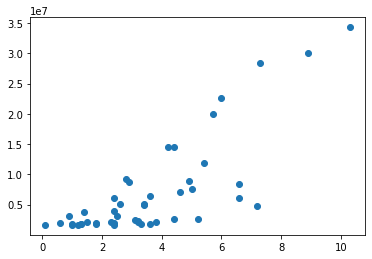

In [21]:
plt.plot(wings_df['AST'],wings_df[['Avg_Salary']], 'o')
# Point guard pay correlates strongly with assists, more than when compared to all players

In [22]:
bigs_df = df_combined[(df_combined.Pos == "C") | (df_combined.Pos == "PF")]
bigs_df.head()
len(bigs_df)

132

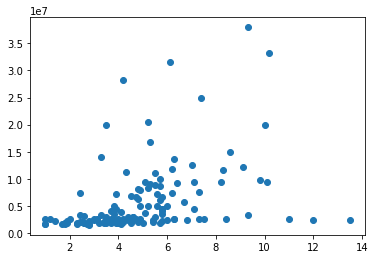

In [23]:
plt.plot(bigs_df['TRB'],bigs_df[['Avg_Salary']], 'o')
#

## LINEAR REGRESSION MODELS ##

### ENTIRE DF ###

In [52]:
# use selected stats as predictor variable 
inputs = ['PTS','AST','TRB','BLK','Age', 'GS', 'VORP']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 4149159.9518831205


### Guards/Wings DF ###

In [42]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'VORP', 'GS']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3715957.523437452


### Bigs DF ###

In [45]:
# use selected stats as predictor variable 
inputs = ['PTS','VORP','BLK','GS', 'TRB', 'DBPM']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# calculate R sq and adjusted R sq
#sal_rsq = model.score(X_test, y_test)
#print(f'R-squared: {sal_rsq}')
#sal_adjusted_rsq = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
#print(f'Adjusted: {sal_adjusted_rsq}')

# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 2655965.449388194


Overall, both of the linear regressions on the positional dataframes performed better than the linear regression on the overall dataframe. 

## DECISION TREE MODEL ##

In [82]:
# use selected stats as predictor variable 
inputs = ['PTS',  'AST', 'TRB', 'Age','PER', 'GS']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [83]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)

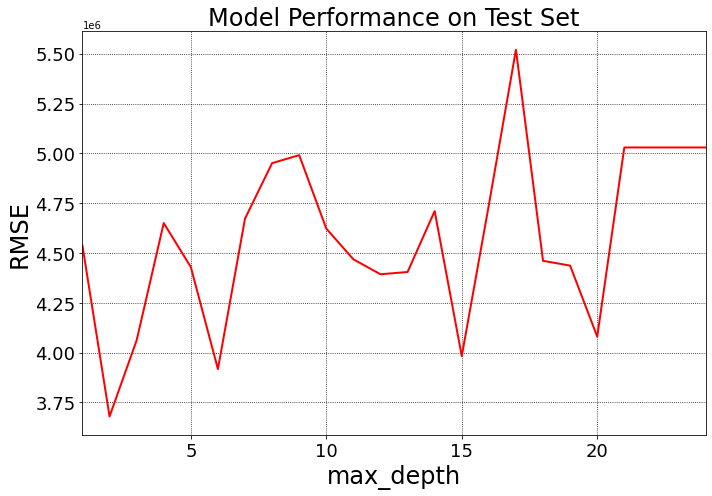

In [84]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [51]:
depth = 2
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3679830.117827943


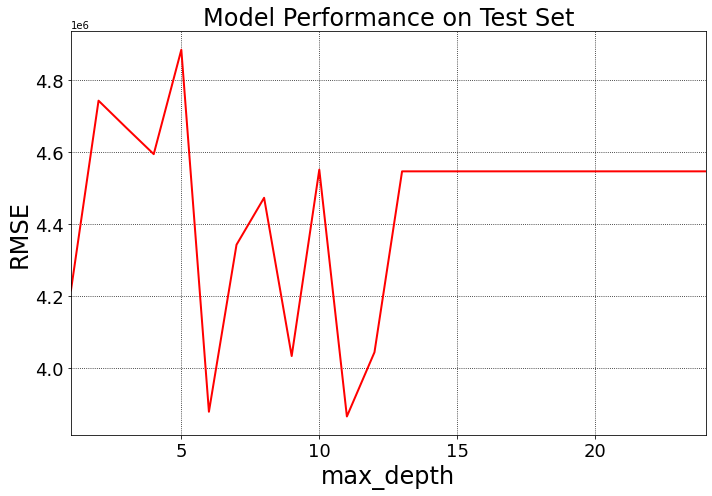

In [76]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [71]:
depth = 6
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3879800.4036424747


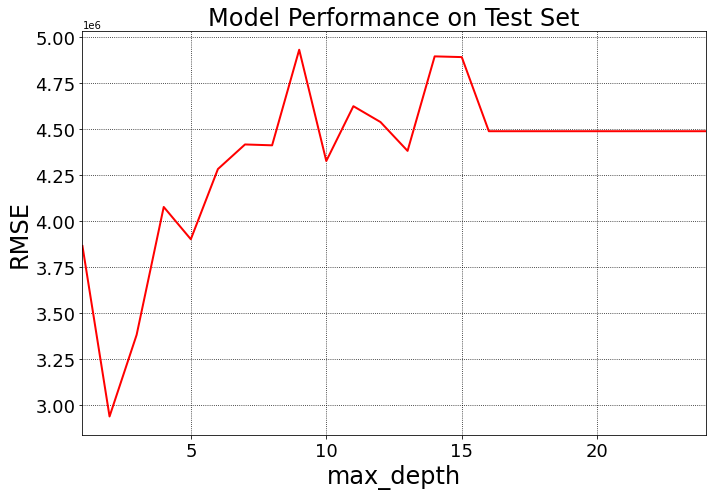

In [86]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'TRB']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [87]:
# use selected stats as predictor variable 
inputs = ['PTS','VORP','TRB']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
depth = 2
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 2939320.551902596


## XGBOOST MODEL ##

In [88]:
# use selected stats as predictor variable 
inputs = ['PTS','Age','PER', 'GS']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [89]:
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3501679.5070671737


In [96]:
# use selected stats as predictor variable 
inputs = ['PTS','VORP','BLK','GS', 'TRB', 'DBPM']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 2102464.718244733


In [97]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'AST']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3300523.229928182


Overall, for looking at the entire DF, the xgboost model performed the best, including for the position based models. The bigs models consistently outperformed the total models by a decent amount, and the guards/wings models slightly outperformed the entire DF models. This makes since as I was able to specify the inputs to more accurately fit positions.